(3024, 4032, 3)
(378, 504, 3)


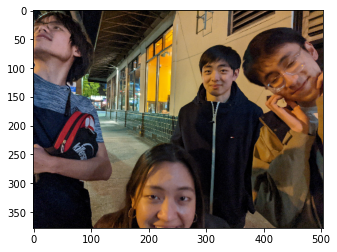

In [1]:
from matplotlib import image
import matplotlib.pyplot as plt

image = image.imread("test.jpg")
print(image.shape)
image = image[::8, ::8, :]
print(image.shape)
plt.imshow(image)

plt.imsave('source_img.png', image)

In [2]:
import numpy as np

bayer_img = np.copy(image)

# Blue is even rows and even cols
bayer_img[::2, ::2, 0] = 0
bayer_img[::2, ::2, 1] = 0

# Red is odd rows and odd cols
bayer_img[1::2, 1::2, 1] = 0
bayer_img[1::2, 1::2, 2] = 0

# Green is odd rows and even cols, plus even rows and odd cols
bayer_img[1::2, ::2, 0] = 0
bayer_img[1::2, ::2, 2] = 0

bayer_img[::2, 1::2, 0] = 0
bayer_img[::2, 1::2, 2] = 0

print(bayer_img[0, 0], bayer_img[1, 0], bayer_img[1, 1], bayer_img[0, 1])

[ 0  0 80] [ 0 78  0] [9 0 0] [ 0 30  0]


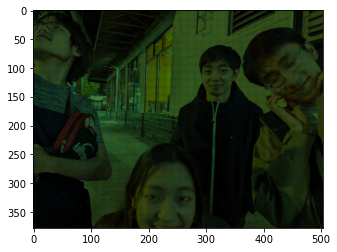

In [3]:
plt.imshow(bayer_img)
plt.imsave('output.png', bayer_img)

In [4]:
def invalid_coord(y, x):
    return y < 0 or x < 0 or y >= image.shape[0] or x >= image.shape[1]


def get_channel(y, x):
    if y % 2 == 0 and x % 2 == 0: # blue
        return 2
    elif y % 2 == 1 and x % 2 == 1: # red
        return 0
    else: # green
        return 1
    

def transfer(y, x, v, c):
    if invalid_coord(y, x):
        return
    new_img[y, x, c].append(v)

    
def transfer_n4(y, x, c):
    transfer(y, x, bayer_img[y, x, c], c)
    transfer(y - 1, x, bayer_img[y, x, c], c)
    transfer(y + 1, x, bayer_img[y, x, c], c)
    transfer(y, x - 1, bayer_img[y, x, c], c)
    transfer(y, x + 1, bayer_img[y, x, c], c)


def transfer_n8(y, x, c):
    transfer_n(y, x, c, 1)


def transfer_n(y, x, c, r):
    for y1 in range(y - r, y + r + 1):
        for x1 in range(x - r, x + r + 1):
            transfer(y1, x1, bayer_img[y, x, c], c)

In [5]:
new_img = np.empty(bayer_img.shape, dtype=object)

for y in range(new_img.shape[0]):
    for x in range(new_img.shape[1]):
        for c in range(new_img.shape[2]):
            new_img[y, x, c] = []

for y in range(new_img.shape[0]):
    for x in range(new_img.shape[1]):
        if y % 2 == 0 and x % 2 == 0: # blue
            transfer_n8(y, x, 2)
        elif y % 2 == 1 and x % 2 == 1: # red
            transfer_n8(y, x, 0)
        else: # green
            transfer_n4(y, x, 1)

new_img_out = np.empty(bayer_img.shape, dtype=np.uint8)

for y in range(new_img.shape[0]):
    for x in range(new_img.shape[1]):
        for c in range(new_img.shape[2]):
            if len(new_img[y,x,c]) == 0:
                print(y, x, c)
            new_img_out[y, x, c] = sum(new_img[y, x, c]) / len(new_img[y, x, c])

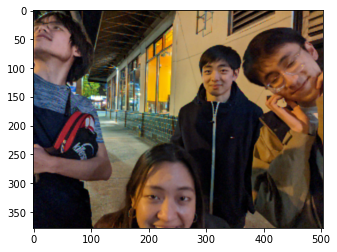

In [6]:
plt.imshow(new_img_out)
plt.imsave('new_img.png', new_img_out)

In [7]:
# Median filtering
import statistics

new_img = np.empty(bayer_img.shape, dtype=object)

for y in range(new_img.shape[0]):
    for x in range(new_img.shape[1]):
        for c in range(new_img.shape[2]):
            new_img[y, x, c] = []

for y in range(new_img.shape[0]):
    for x in range(new_img.shape[1]):
        c = get_channel(y, x)
        transfer_n(y, x, c, 2)

new_img_out = np.empty(bayer_img.shape, dtype=np.uint8)

for y in range(new_img.shape[0]):
    for x in range(new_img.shape[1]):
        for c in range(new_img.shape[2]):
            if len(new_img[y,x,c]) == 0:
                print(y, x, c)
            new_img_out[y, x, c] = np.median(np.array(new_img[y, x, c], dtype=int))

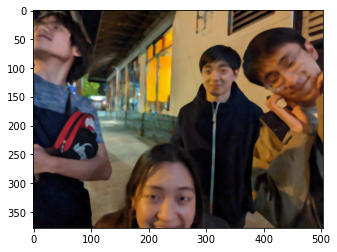

In [8]:
plt.imshow(new_img_out)
plt.imsave('new_img_median.png', new_img_out)

In [9]:
import math
from sklearn.cluster import KMeans


def distance(y1, x1, y2, x2):
    return math.sqrt((y1 - y2) ** 2 + (x1 - x2) ** 2)


def get_priors(y, x, r):
    samples = []
    weights = []
    for y1 in range(y - r, y + r + 1):
        for x1 in range(x - r, x + r + 1):
            if invalid_coord(y1, x1):
                continue
            samples.append(new_img_out[y1, x1, :])
            weights.append(1 / (distance(y1, x1, y, x) + 1))
    samples = np.vstack(samples)
    weights = np.array(weights)
    
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(samples, sample_weight=weights)
    return kmeans.cluster_centers_[0], kmeans.cluster_centers_[1]
    

get_priors(3, 18, 2)

(array([74.68962733, 70.8227994 , 38.5383998 ]),
 array([81.73510798, 77.49035156, 60.29921496]))

In [10]:
values = [[], [], []]

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        c = get_channel(y, x)
        values[c].append(new_img_out[y, x, c])

stds = [np.std(values[0]), np.std(values[1]), np.std(values[2])]
print(stds)

[66.76811966874162, 54.084576152597194, 42.23306247493333]


In [11]:
def get_mean(y, x, prior_1, prior_2):
    c = get_channel(y, x)
    return (bayer_img[y, x, c] - prior_1[c]) / (prior_2[c] - prior_1[c])


def get_variance(y, x, center_x, center_y, global_var, prior_1, prior_2):
    var = global_var * (1 + 6 * distance(y, x, center_x, center_y))
    return (var / (prior_2[c] - prior_1[c])) ** 2


def optimal_a(y, x, r, prior_1, prior_2):
    c = get_channel(y, x)
    numerator = 0
    denominator = 0
    
    variances = []
    means = []
    
    for y1 in range(y - r, y + r + 1):
        for x1 in range(x - r, x + r + 1):
            if invalid_coord(y1, x1):
                continue
            variance = get_variance(y1, x1, y, x, stds[c], prior_1, prior_2)
            if y == 9 and x == 10:
                print(y1, x1, y, x, stds[c], variance)
            mean = get_mean(y1, x1, prior_1, prior_2)
            #print(y1, x1, mean)
            numerator += mean / variance
            denominator += 1 / variance
            
            variances.append(variance)
            means.append(mean)
    
    a_star = numerator / denominator
    
    a_star_prob = 0
    a0_prob = 0
    a1_prob = 0
    
    for i in range(len(variances)):
        a_star_prob -= (a_star - means[i]) ** 2 / (2 * variances[i])
        a0_prob -= (0 - means[i]) ** 2 / (2 * variances[i])
        a1_prob -= (1 - means[i]) ** 2 / (2 * variances[i])
    
    a_star_prob += math.log(0.2) # Gamma value
    probs = [a_star_prob, a0_prob, a1_prob]
    a_vals = [a_star, 0, 1]
    if y == 9 and x == 10:
        print(probs)
    
    return a_vals[np.argmax(probs)]

In [12]:
from tqdm.notebook import tqdm

KERNEL = 2
new_img_2color = np.zeros(image.shape)

for y in tqdm(range(35)): #tqdm(range(image.shape[0])):
    for x in tqdm(range(35), leave=False): #tqdm(range(image.shape[1]), leave=False):
        prior_1, prior_2 = get_priors(y, x, KERNEL)
        a = optimal_a(y, x, KERNEL, prior_1, prior_2)
        if y == 9 and x == 10:
            print(prior_1, prior_2, a)
        new_img_2color[y, x, :] = prior_1 * (1 - a) + prior_2 * a

7 8 9 10 54.084576152597194 613.5899787925683
7 9 9 10 54.084576152597194 394.8835342662841
7 10 9 10 54.084576152597194 321.10096308226935
7 11 9 10 54.084576152597194 394.8835342662841
7 12 9 10 54.084576152597194 613.5899787925683
8 8 9 10 54.084576152597194 394.8835342662841
8 9 9 10 54.084576152597194 170.94458193840097
8 10 9 10 54.084576152597194 93.100279236871
8 11 9 10 54.084576152597194 170.94458193840097
8 12 9 10 54.084576152597194 394.8835342662841
9 8 9 10 54.084576152597194 321.10096308226935
9 9 9 10 54.084576152597194 93.100279236871
9 10 9 10 54.084576152597194 1.9000056987116527
9 11 9 10 54.084576152597194 93.100279236871
9 12 9 10 54.084576152597194 321.10096308226935
10 8 9 10 54.084576152597194 394.8835342662841
10 9 9 10 54.084576152597194 170.94458193840097
10 10 9 10 54.084576152597194 93.100279236871
10 11 9 10 54.084576152597194 170.94458193840097
10 12 9 10 54.084576152597194 394.8835342662841
11 8 9 10 54.084576152597194 613.5899787925683
11 9 9 10 54.084

[0. 0. 0.]
[0 0 0]


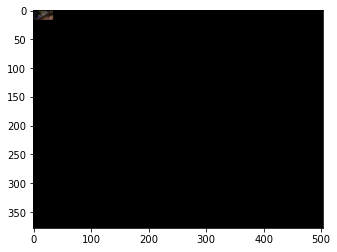

In [61]:
print(new_img_2color[18, 3, :])
new_img_2color = new_img_2color.astype(np.uint8)
print(new_img_2color[18, 3, :])

plt.imshow(new_img_2color)
plt.imsave('new_img_2color.png', new_img_2color)

In [87]:
p1, p2 = get_priors(9, 10, KERNEL)
print(p1, p2)
a = optimal_a(9, 10, KERNEL, p1, p2)
print(a)
print(p1 * (1-a) + a*p2)

[33.77859342 30.53799605 31.15209849] [73.01561007 63.02702104 89.15922562]
7 8 9 10 54.084576152597194 613.5899787925683
7 9 9 10 54.084576152597194 394.8835342662841
7 10 9 10 54.084576152597194 321.10096308226935
7 11 9 10 54.084576152597194 394.8835342662841
7 12 9 10 54.084576152597194 613.5899787925683
8 8 9 10 54.084576152597194 394.8835342662841
8 9 9 10 54.084576152597194 170.94458193840097
8 10 9 10 54.084576152597194 93.100279236871
8 11 9 10 54.084576152597194 170.94458193840097
8 12 9 10 54.084576152597194 394.8835342662841
9 8 9 10 54.084576152597194 321.10096308226935
9 9 9 10 54.084576152597194 93.100279236871
9 10 9 10 54.084576152597194 1.9000056987116527
9 11 9 10 54.084576152597194 93.100279236871
9 12 9 10 54.084576152597194 321.10096308226935
10 8 9 10 54.084576152597194 394.8835342662841
10 9 9 10 54.084576152597194 170.94458193840097
10 10 9 10 54.084576152597194 93.100279236871
10 11 9 10 54.084576152597194 170.94458193840097
10 12 9 10 54.084576152597194 394.8